# Assignment 4: Modeling Epidemics

In [1]:
import time

import EoN as eon
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

## Part 1: Outbreak Modeling [40 Points]

In [2]:
def load_flu_network():
    # Read the graph
    G = nx.read_edgelist("fludata.txt", nodetype=int, data=(("weight", float),))

    return G

### 1.1

In [3]:
def simulate_outbreak(G, n_iter, initial_infected=325, tmax=10, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        n_iter : int
              Number of simulations to run.
        initial_infected : int
                        The node that is initially infected
        tmax : int
        beta : float
        mu : float

    Returns:
        simulation_runs : list[tuple] -
                       This is a list like object of tuples of the
                       form (t, S, I). Each tuple (t, S, I) represents
                       a simulated run, where t, S, I are vectors representing
                       the time periods, and the corresponding numbers of susceptible
                       and infected people.
    """
    simulation_runs = []
    
    for i in tqdm(range(n_iter), desc="Simulating outbreaks"):
        t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, tmax=tmax, initial_infecteds=[initial_infected])
        if I[-1] == 0:  
            t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, tmax=tmax, initial_infecteds=[initial_infected])
        simulation_runs.append((t, S, I))
        
    return simulation_runs


def plot_outbreaks(simulation_runs, save=False):
    """
    Inputs:
        simulation_runs : list[tuple]
                      The list like object of tuples returned by `simulate_outbreak`.
        save : bool
           Whether to save the figure.
    """
    plt.figure(figsize=(12, 8))

    for idx, (t, S, I) in enumerate(simulation_runs):
        plt.plot(t, I, label=f'Infected Run {idx+1}')
        plt.plot(t, S, label=f'Susceptible Run {idx+1}')

    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
    plt.title('SIS Model Simulation of Outbreak')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig("1_1.png")

    plt.show()

### 1.2

In [12]:
def get_exponent(simulation_run, I_thrsh=100):
    """
    Inputs:
        simulation_run : tuple
                      A tuple of (t, S, I) as specified in `simulate_outbreak()`
        I_thrsh : int
               Threshold of I. We only fit the curve where I<=I_thrsh

    Returns:
        tau : float
    """
    #tau = 0.0
    
    t, S, I = simulation_run
    
    mask = np.array(I) <= I_thrsh
    t_fil = np.array(t)[mask]
    I_fil = np.array(I)[mask]  
    
    if len(t_fil) < 2 or len(I_fil) < 2:
        raise ValueError("Not enough data points below the infection threshold for fitting.")
    
    def exponential_func(t,tau):
        return np.exp(t/tau)
    params,i = curve_fit (exponential_func, t_fil,I_fil, p0=[1.0])
    tau=params[0]
    return tau


def plot_curve_fit(simulation_run, tau, I_thrsh=100, save=False):
    """
    Inputs:
        simulation_run : tuple
        I_thrsh : int
        tau : float
        save : bool
    """
    #r2 = 0.0  # R^2 to be computed
    
    t, S, I = simulation_run
    
    mask = np.array(I) <= I_thrsh
    t_fil = np.array(t)[mask]
    I_fil = np.array(I)[mask]


    def exponential_func(t,tau):
        return np.exp(t/tau)
    
    if len(t_fil) < 2:
         raise ValueError("Not enough data points below the infection threshold for fitting.")

    I_exp = exponential_func(t_fil, tau)

    r2 = r2_score(I_fil,I_exp)
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, I, 'o', label='Observed data')
    plt.plot(t_fil, I_exp, '-', label=f'Fitted curve (tau={tau:.4f})')
    plt.axhline(y=I_thrsh, color='r', linestyle='--', label=f'I threshold = {I_thrsh}')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Nodes')
    plt.title('Exponential Fit to the SIS Model Simulation')
    plt.legend()
    plt.grid(True)

    if save:
        plt.savefig("1_2.png")

    plt.show()
    return r2

### 1.3

In [13]:
def calculate_theoretical_taus(G, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        beta : float
        mu : float

    Returns:
        tau_rand : float
        tau_slide : float
        tau_book : float
    """
    degrees = [degree for n, degree in G.degree()]
    avg_degree = np.mean(degrees)
    second_moment_degree = np.mean([d**2 for d in degrees])
    
    A = nx.adjacency_matrix(G).todense()
    eigenvalues = np.linalg.eigvals(A)
    largest_eigenvalue = np.max(eigenvalues)
    

    tau_slide = 1 / (beta * largest_eigenvalue - mu)
    tau_rand = 1 / (avg_degree * beta - mu)
    tau_book = avg_degree / (beta * second_moment_degree - mu * avg_degree)
    
    return tau_rand, tau_slide, tau_book


def compare_taus(empirical_taus, tau_rand, tau_slide, tau_book, save=False):
    """
    This function visually compares the empirical_taus, tau_rand, tau_slide,
    and tau_book on a boxplot.

    Inputs:
        empirical_taus : list[float]
                      List-like object of floats containing the list of tau's
        tau_rand : float
        tau_slide : float
        tau_book : float
        save : bool
    """
    
    plt.figure(figsize=(10, 6))

    theoretical_taus = [tau_rand, tau_slide, tau_book]
    labels = ['Empirical Taus', 'Tau Rand', 'Tau Slide', 'Tau Book']

    data = [empirical_taus] + [[tau] for tau in theoretical_taus]

    plt.boxplot(data, vert=True, patch_artist=True, labels=labels)
    plt.ylabel('Tau Values')
    plt.title('Comparison of Empirical and Theoretical Tau Values')

    if save:
        plt.savefig("1_3.png")

    plt.show()

### 1.4

In [14]:
def calculate_theoretical_endemic_size(G, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        beta : float
        mu : float

    Returns:
        theoretical_endemic_size : int
    """
    #theoretical_endemic_size = 0.0

    N = G.number_of_nodes()
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees)
    second_moment_degree = np.mean([d**2 for d in degrees])
    
    endemic_threshold = beta * second_moment_degree/(mu * avg_degree)
    
    if endemic_threshold <= 1:
        return 0.0
    
    endemic_pre = 1- (1/endemic_threshold)
    theoretical_endemic_size = endemic_pre * N
    
    return theoretical_endemic_size


def compare_endemic_sizes(
    empirical_endemic_sizes, theoretical_endemic_size, save=False
):
    """
    Inputs:
        empirical_endemic_sizes : list[int]
                               List-like object of int's representing a distribution of
                               empirical endemic sizes from multiple simulation runs.
                               Refer to cell 1.5 to see how it works.
        theoretical_endemiz_size : int
        save : bool
    """
    plt.figure(figsize=(10, 6))

    plt.boxplot(empirical_endemic_sizes, vert=False, widths=0.7, patch_artist=True)
    
    plt.scatter(theoretical_endemic_size, 1, color='red', zorder=5, label=f'Theoretical Endemic Size: {theoretical_endemic_size:.2f}')
    
    plt.xlabel('Endemic Sizes')
    plt.title('Comparison of Empirical and Theoretical Endemic Sizes')
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("1_4.png")

    plt.show()

### 1.5

>>>>> Results for Part 1 <<<<<


Simulating outbreaks:   0%|          | 0/10 [00:00<?, ?it/s]

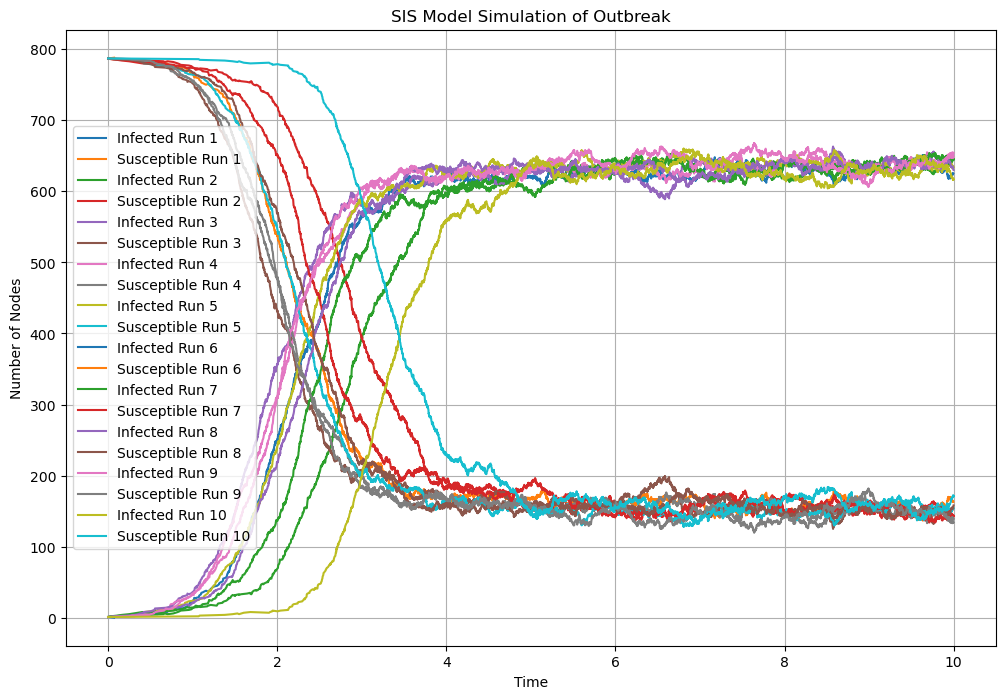

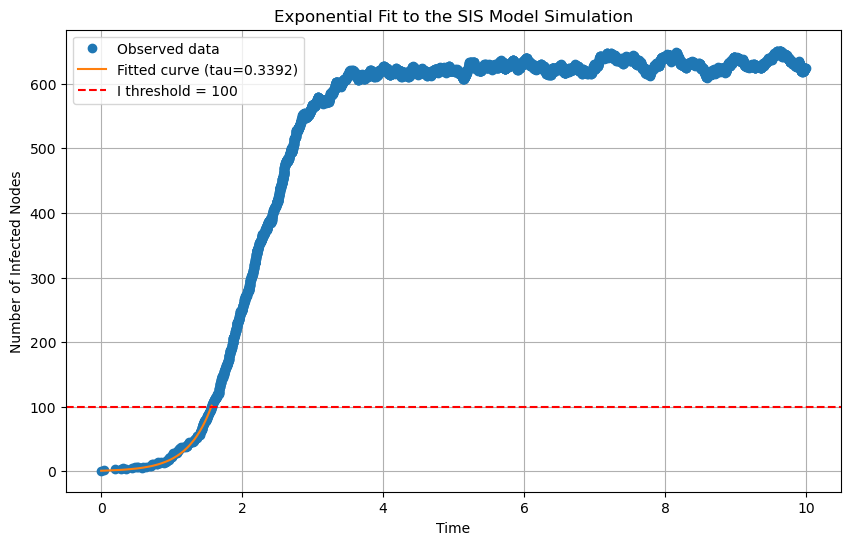

> Part 1.2 <
tau=0.34, R2=0.9879


Simulating outbreaks:   0%|          | 0/25 [00:00<?, ?it/s]


> Part 1.3 <
tau_rand=0.3996, tau_slide=0.0150, tau_book=0.3499
Empirical distribution of tau
Count=25	Mean=0.428	std=0.113
Min=0.285	25%=0.337	50%=0.391	75%=0.495	Max=0.735


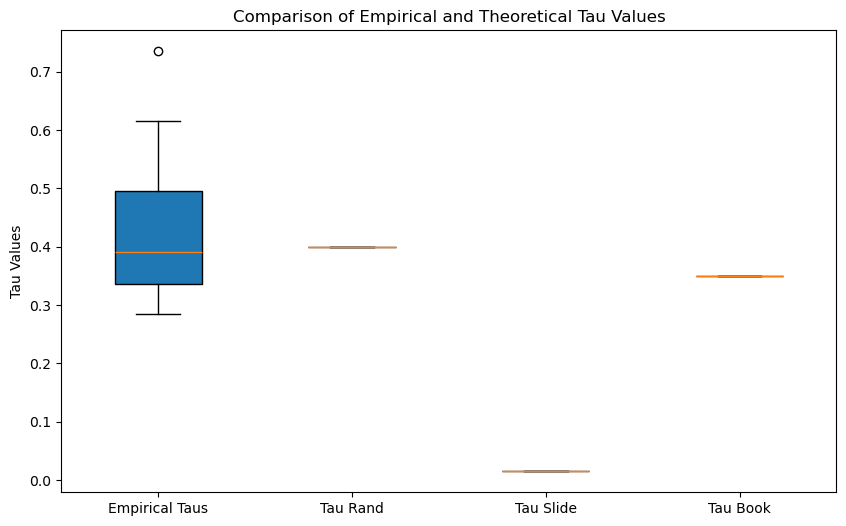


> Part 1.4 <


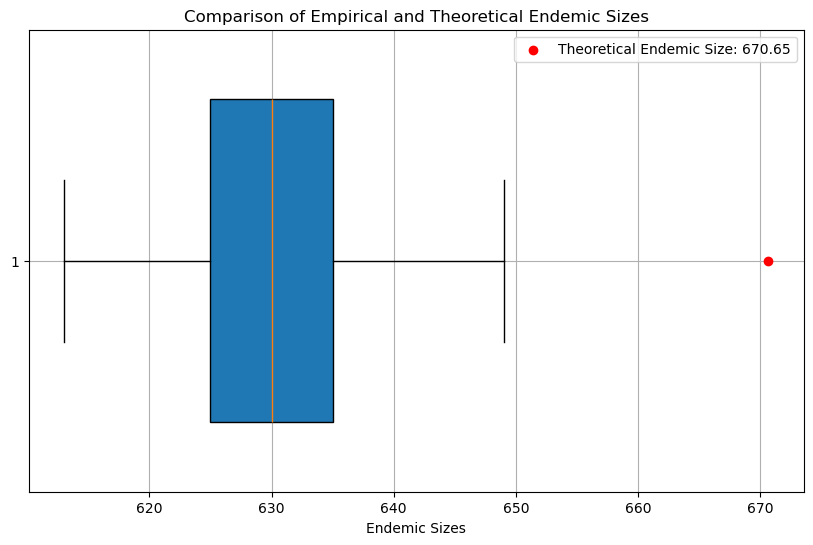

Theoretical endemic size=670.65
Empirical distribution of simulated endemic size
Count=25	Mean=628.960	std=8.820
Min=613.000	25%=625.000	50%=630.000	75%=635.000	Max=649.000


In [15]:
# Do not modify
print(">>>>> Results for Part 1 <<<<<")


G = load_flu_network()

# Generate 10 simulation runs for plotting
simulation_runs = simulate_outbreak(G, 10)

plot_outbreaks(simulation_runs)

tau = get_exponent(simulation_runs[0])
r2 = plot_curve_fit(simulation_runs[0], tau)
print("> Part 1.2 <")
print(f"tau={tau:.2f}, R2={r2:.4f}")

simulation_runs = simulate_outbreak(G, 25)

empirical_taus = []
empirical_endemic_sizes = []
for run in simulation_runs:
    empirical_taus.append(get_exponent(run))
    empirical_endemic_sizes.append(run[2][-1])

tau_rand, tau_slide, tau_book = calculate_theoretical_taus(G)
print("\n> Part 1.3 <")
print(f"tau_rand={tau_rand:.4f}, tau_slide={tau_slide:.4f}, tau_book={tau_book:.4f}")

print("Empirical distribution of tau")
def describe(x):
    print(
        "Count={count}\tMean={mean:.3f}\tstd={median:.3f}\n"
        "Min={min:.3f}\t25%={p25:.3f}\t50%={p50:.3f}\t75%={p75:<.3f}\tMax={max:.3f}".format(
            count=len(x),
            mean=np.mean(x),
            median=np.std(x),
            min=min(x),
            p25=np.percentile(x, 25),
            p50=np.median(x),
            p75=np.percentile(x, 75),
            max=max(x),
        )
    )
describe(empirical_taus)

compare_taus(empirical_taus, tau_rand, tau_slide, tau_book)

print("\n> Part 1.4 <")
theoretical_endemic_size = calculate_theoretical_endemic_size(G)

compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size)
print(f"Theoretical endemic size={theoretical_endemic_size:.2f}")
print("Empirical distribution of simulated endemic size")
describe(empirical_endemic_sizes)

### 1.5 Written Response

Answer: The R square is 0.9879, so the exponential model fit the outbreak data perfectly.It explained 98.79% of the variability in the number of infections.The exponential curve tau 0.34 is a close match to tau_rang 0.39. 
In part 1.3, The theorical tao rand 0.3996 is close to the empirical mean 0.453.Therefore, it is a reasonable estimate within the spread of the empirical data. Tau slide and Tau book are lower which means these do not match the empirical observations. 
In part 1.4, the range of empirical distribution is from 0 to 670, while the theoretical value of 670.65 is close to the maximum empirical value, therefore, model in part 1.4 can provide a reasonable fit for the empirical distribution of endemic sizes.

## Part 2: Transmission Rate Variation  $\beta$ [25 Points]

### 2.1 Minimum Transmission Rate for Epidemic

In [8]:
def simulate_beta_sweep(
    G,
    n_sims,
    beta_min=0.001,
    beta_max=0.04,
    beta_samples=40,
    initial_infected=325,
    tmax=10,
    mu=0.5,
):
    """
    Generate a list of betas. Run multiple simulations for each beta.
    Save the results.

    Inputs:
        G : nx.Graph
        n_sims : int
              Number of simulations (or runs) for each beta value
        beta_min : float
                Minimum beta to simulate
        beta_max : float
                Maximum beta to simulate
        beta_samples : int
                    The number of betas to simulate. That is, the function will
                    generate `beta_samples` betas between `beta_min` and `beta_max`.
        initial_infect : int
                      Initial infected node
        tmax : int
        mu : float

    Returns:
        betas : list[float]
             The list of betas the function has generated.
        beta_runs : list[list[tuple]]
                 Simulation results corresponding to `betas`. It is a list where
                 each itemis a list of tuples, representing multiple simulations
                 for a particular beta. The tuple is in the form of (t, S, I) as
                 in `simulate_outbreak` in Part 1.
    """
    betas = []
    beta_runs = []
    
    betas = np.linspace(beta_min, beta_max, beta_samples)

    for beta in betas:
        runs = []
        for i in range(n_sims):
            run = simulate_outbreak(G, 1, initial_infected=initial_infected, tmax=tmax, beta=beta, mu=mu)[0]
            runs.append(run)
        beta_runs.append(runs)

    return betas, beta_runs


def extract_average_tau(beta_runs):
    """
    Estimate the average tau value for each beta value.

    Inputs:
        beta_runs : list[list[tuple]]
                 See docstring of `simulate_beta_sweep` above.

    Returns:
        avg_taus : list[float]
                A list like object, where each item is the estimated
                average tau values of the corresponding simulations in
                `beta_runs` for a particular beta.
    """

    avg_taus = []
    
    for runs in beta_runs:
        taus = [get_exponent(run) for run in runs]
        avg_tau = np.mean(taus)
        avg_taus.append(avg_tau)

    return avg_taus


def plot_beta_tau_curves(betas, avg_taus, t, save=False):
    """
    Inputs:
        betas : list[float]
        avg_taus : list[float]
        t : list[float]
        save: bool
    """
    plt.figure(figsize=(10, 6))

    for beta, tau in zip(betas, avg_taus):
        I_pred = np.exp(t * tau)
        plt.plot(t, I_pred, label=f'Beta = {beta:.3f}')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Nodes')
    plt.title('Exponential Growth Curves for Different Betas')
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("2_1.png")

    plt.show()

### 2.2

In [9]:
def extract_average_endemic_size(beta_runs):
    """
    Given the simulated data, compute the average size of the endemic state for
    each beta value using the simulation data in `beta_runs`.

    Inputs:
        beta_runs : list[list[tuple]]
                 See docstring of `simulate_beta_sweep()` above.

    Returns:
        avg_ends : list[float]
                A list-like object of floats. Each item is the average endemic size
                for a particular beta value estimated using the corresponding simulation
                results in `beta_runs`.
    """
    avg_endemic_sizes = []
    
    for runs in beta_runs:
        end_sizes = [run[2][-1] for run in runs]
        avg_end_size = np.mean(end_sizes)
        avg_endemic_sizes.append(avg_end_size)

    return avg_endemic_sizes


def calculate_theoretical_endemic(G, betas, mu=0.5):
    """
    Compute the theoretical endemic size for each beta value in `betas`,
    assuming random distribution.

    Additionally, compute the minimum theoretical beta for
    epdemic to occur, assuming random distribution and
    arbitrary distribution respectively.

    Inputs:
        G : nx.Graph
        betas : list[float]
             List of betas used to compute `theoretical_endemics`.
             Each item of the returned `theoretical_endemics` corresponds
             to a beta value in the `betas` list at the same index.
        mu : float

    Returns:
        theoretical_endemics : list[float]
                            A list-like object of theoretical endemic sizes
                            corresponding to the betas in the `betas` parameter.
        rand_dist_min_beta : float
        arb_dist_min_beta : float
    """

    theoretical_endemic_sizes = []
    rand_dist_min_beta = arb_dist_min_beta = 0.0

    N = G.number_of_nodes()
    avg_degree = np.mean([deg for i, deg in G.degree()])
    squared_degree = np.mean([deg**2 for i,deg in G.degree()])
   
    rand_dist_min_beta = mu / avg_degree
    arb_dist_min_beta = mu / (squared_degree / avg_degree - 1)
    
    theoretical_endemic_sizes = []
    for beta in betas:
        endemic_fraction = 1 - (mu / (beta * avg_degree))
        if endemic_fraction <= 0:
            endemic_size = 0.0
        else:
            endemic_size = N * endemic_fraction
        theoretical_endemic_sizes.append(endemic_size)

    return theoretical_endemic_sizes, rand_dist_min_beta, arb_dist_min_beta


def compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemic_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
    save=False,
):
    """
    Plot a figure to visually compare the average endemic sizes from simulation vs
    the theoretical endemic sizes for different beta values. Also, it shows the minimum
    beta thresholds for an endemic to occur assuming random and arbitrary distributions
    respectively.

    Inputs:
        betas : list[float]
             A list-like object of betas corresponding to `avg_endemic_sizes` and `theoretical_endemic_sizes`
        avg_endemic_sizes : list[float]
                        The average endemic sizes as returned by
                        `extract_average_endemic_size`. Each element
                        corresponds to a beta value in the `betas` parameter
                        at the same index.
        theoretical_endemic_sizes : list[float]
                                  The theoretical endemic sizes. Each element
                                  corresponds to a beta value in the `betas`
                                  parameter at the same index.
        rand_dist_min_beta : float
        arb_dist_min_beta : float
        save : bool
    """
    plt.figure(figsize=(10, 6))

    plt.plot(betas, avg_endemic_sizes, 'o-', label='Average Endemic Sizes (Simulation)')
    plt.plot(betas, theoretical_endemic_sizes, 'x-', label='Theoretical Endemic Sizes')

    plt.axvline(x=rand_dist_min_beta, color='r', linestyle='--', label=f'Rand Dist Min Beta = {rand_dist_min_beta:.3f}')
    plt.axvline(x=arb_dist_min_beta, color='b', linestyle='--', label=f'Arb Dist Min Beta = {arb_dist_min_beta:.3f}')

    plt.xlabel('Beta')
    plt.ylabel('Endemic Size')
    plt.title('Comparison of Endemic Sizes vs Beta')
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("2_2.png")

    plt.show()

### 2.3

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating outbreaks:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\zhaoj\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_8688\994770255.py:91: RuntimeWarning: overflow encountered in exp
  I_pred = np.exp(t * tau)


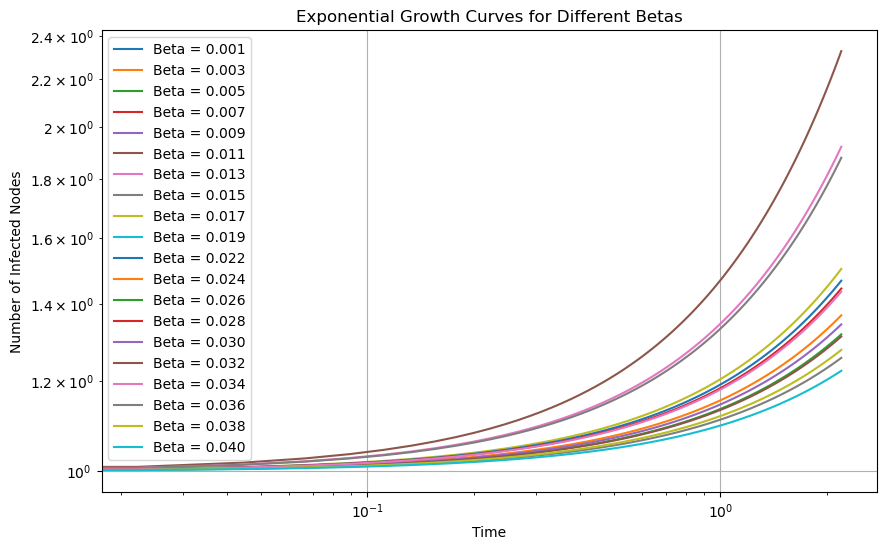

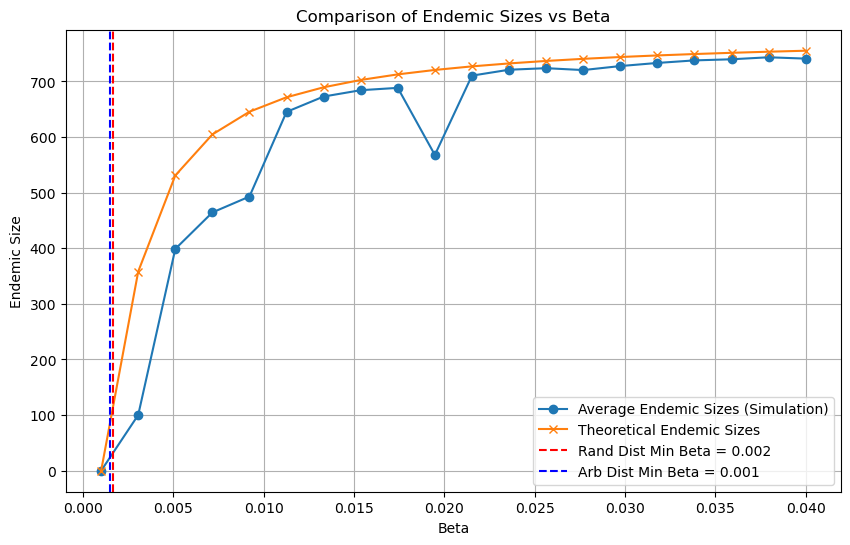

>>>>> Results for Part 2 <<<<<
Avg_taus = [28101046.31   808782.71  1287429.22  6700252.62   338352.16        0.38
        0.3         0.29        0.18  8633094.2         0.17        0.14
        0.13        0.17        0.13        0.12        0.16        0.1
        0.11        0.09]

Avg endemic size = [  0. 100. 399. 464. 493. 645. 673. 684. 688. 568. 710. 721. 724. 720.
 728. 733. 738. 740. 743. 741.]

Theo endemic size = [  0. 358. 531. 605. 646. 671. 689. 703. 713. 721. 727. 732. 737. 741.
 744. 747. 749. 751. 753. 755.]

Min beta for random distribution = 0.00167
Min beta for arbitrary distribution = 0.00149


In [10]:
# do not modify
### 2.1
G = load_flu_network()

betas, beta_runs = simulate_beta_sweep(G, 5, beta_samples=20)

avg_taus = extract_average_tau(beta_runs)
times = np.linspace(0, 2.2, 100)

plot_beta_tau_curves(betas, avg_taus, t=times)

### 2.2
avg_endemic_sizes = extract_average_endemic_size(beta_runs)

(
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
) = calculate_theoretical_endemic(G, betas)

compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
)

# print results
print(">>>>> Results for Part 2 <<<<<")
with np.printoptions(precision=2, suppress=True):
    print(f"Avg_taus = {np.array(avg_taus)}\n")

with np.printoptions(precision=0, suppress=True):
    print(f"Avg endemic size = {np.array(avg_endemic_sizes)}\n")
    print(f"Theo endemic size = {np.array(theoretical_endemics_sizes)}\n")

print(f"Min beta for random distribution = {rand_dist_min_beta:.5f}")
print(f"Min beta for arbitrary distribution = {arb_dist_min_beta:.5f}")

### 2.3 Written Response

Answer: The endemic size in simulation and theoretica have similar trend, the average endemic sizes increase rapidly from 0.001 to 0.01. The theoreticl endemic size is slightly higher than the average endemic sizes. The minimum beta values are very low which are 0.001 and 0.002.In conclusion, the theoretical endemic size captures the experimental size and the trend. The low minimum beta values for random (0.00167) and arbitrary (0.00149) provide a good indication of the threshold to start the epidemic. In conclusion, the theoretical model effectively predicts the behavior of infection spread. 

## Part 3
### 3.1 

In [20]:
def sweep_initial_infected(G, tmax=10, beta=0.01, mu=0.5):
    """
    Compute the taus for each node.

    Inputs:
        G : nx.Graph
        tmax : int
        beta : float
        mu : float
    Returns:
        taus : list[float]
            List of tau's corresponding to the `nodes` return value below.
        nodes : list[int]
    """
    taus = []
    nodes = []

    for node in G.nodes:
        status = {n: 'S' for n in G.nodes}
        status[node] = 'I'  

        infected_count = [1]  

        for t in range(tmax):
            new_status = status.copy()
            for n in G.nodes:
                if status[n] == 'I':
                    if np.random.rand() < mu:
                        new_status[n] = 'S'
                    for neighbor in G.neighbors(n):
                        if status[neighbor] == 'S' and np.random.rand() < beta:
                            new_status[neighbor] = 'I'
            
            status = new_status
            infected_count.append(sum(1 for s in status.values() if s == 'I'))
        
        if sum(infected_count) > 2 * infected_count[0]:  
            tau = np.mean(infected_count) / tmax  
            taus.append(tau)
            nodes.append(node)
    
    return taus, nodes


    

# Compute centrality metrics
def compute_centrality(G, nodes):
    """
    Inputs:
        G : nx.Graph
        nodes : list[int]
             A list of nodes for which we compute centralities.
    Returns:
        cent_dict : dict[list[float]]
                  The keys of the dict are 'deg', 'clo', 'bet' and 'eig'.
                  The values are lists of floats representing the corresponding
                  centrality for each node in the `nodes` parameter.

    """
    deg_cen = []
    clo_cen = []
    bet_cen = []
    eig_cen = []

    deg_cent = nx.degree_centrality(G)
    clo_cent = nx.closeness_centrality(G, wf_improved=False)
    bet_cent = nx.betweenness_centrality(G)
    eig_cent = nx.eigenvector_centrality(G)
  

    for node in nodes:
        deg_cen.append(deg_cent[node])
        clo_cen.append(clo_cent[node])
        bet_cen.append(bet_cent[node])
        eig_cen.append(eig_cent[node])
    
    cent_dict = {"deg": deg_cen, "clo": clo_cen, "bet": bet_cen, "eig": eig_cen}
    return cent_dict

### 3.2

In [21]:
def calculate_person_correlation(taus, cent_dict):
    """
    Inputs:
        taus : list[float]
        cent_dict : dict[list[float]]
                 See docstring in `compute_centrality`

    Returns:
        r_dict : dict[tuple[float, float]]
              The keys of the dict are 'deg', 'clo', 'bet' and 'eig'.
              The values are tuples of (Pearson coefficient, p-value).
    """
    """r_deg = r_clo = r_bet = r_eig = (
        0.0,  # Pearson correlation coefficient
        0.0,  # p-value
    )
    """
    
    r_deg = pearsonr(taus, cent_dict['deg'])
    r_clo = pearsonr(taus, cent_dict['clo'])
    r_bet = pearsonr(taus, cent_dict['bet'])
    r_eig = pearsonr(taus, cent_dict['eig'])

    
    r_dict = {"deg": r_deg, "clo": r_clo, "bet": r_bet, "eig": r_eig}
    return r_dict


def plot_centrality_vs_tau(taus, cent_dict, r_dict, save=False):
    """
    Inputs:
        taus : list[float]
            See docstring in `sweep_initial_infected`
        cent_dict : dict[list[float]]
                 See docstring in `compute_centrality`
        r_dict : dict[tuple[float, float]]
              See docstring in  `calculate_person_correlation`

        save: bool
    """

    centralities = ['deg', 'clo', 'bet', 'eig']
    titles = {
        'deg': 'Degree Centrality',
        'clo': 'Closeness Centrality',
        'bet': 'Betweenness Centrality',
        'eig': 'Eigenvector Centrality'
    }

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for i, cent in enumerate(centralities):
        ax = axs[i//2, i%2]
        ax.scatter(cent_dict[cent], taus)
        r, p = r_dict[cent]
        ax.set_title(f"{titles[cent]}\nPearson r: {r:.2f}, p-value: {p:.2e}")
        ax.set_xlabel(titles[cent])
        ax.set_ylabel('Tau')
    
    plt.tight_layout()
    
    if save:
        plt.savefig("3_2.png")

    plt.show()

### 3.3

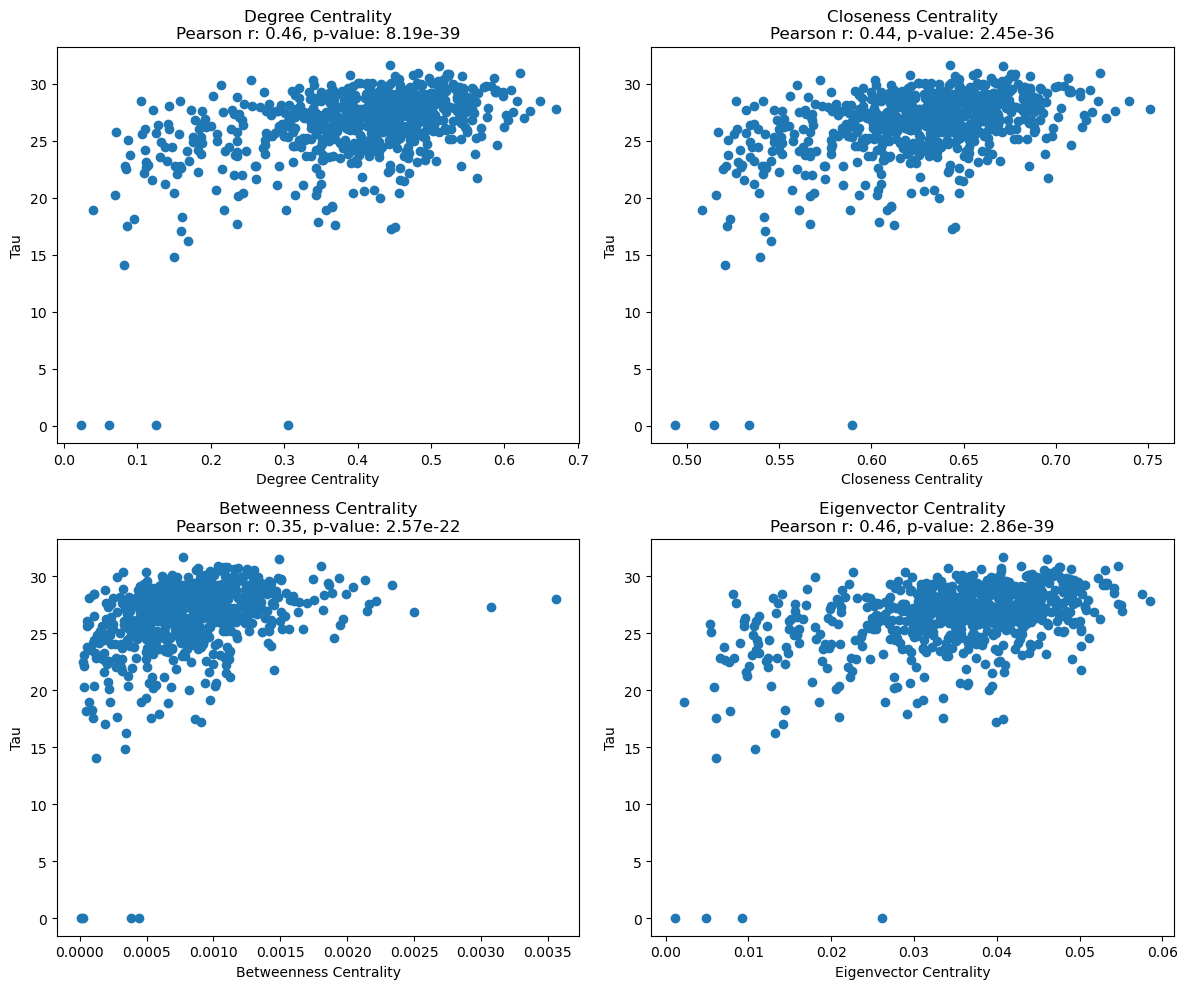

Number of included nodes = 732
bet = 0.3484, pvalue = 0.0000
clo = 0.4419, pvalue = 0.0000
deg = 0.4557, pvalue = 0.0000
eig = 0.4582, pvalue = 0.0000
Elapsed time =  2.10 minutes


In [22]:
# do not modify
start_time = time.time()
G = load_flu_network()

taus, nodes = sweep_initial_infected(G)
cent_dict = compute_centrality(G, nodes)

r_dict = calculate_person_correlation(taus, cent_dict)
plot_centrality_vs_tau(taus, cent_dict, r_dict)

print(f"Number of included nodes = {len(nodes)}")
for k in sorted(r_dict):
    coeff, pvalue = r_dict[k]
    print(f"{k} = {coeff:.4f}, pvalue = {pvalue:.4f}")

# We don't grade by how long it takes. This is purly informational.
seconds_elapsed = time.time() - start_time
print(f"Elapsed time = {seconds_elapsed/60 : .2f} minutes")

### 3.3 Written Response

Answer: Based on the the correlatino coefficient in the centrality metrics, Eigenvector centrality has the highest correlation coefficient, 0.4582, which meansitt is better at predicting the spreed of an outbreak. As the well-connected nodes are expected to spread the outbreak faster, Eigenvector centrality and Degree Centrality have the highest and 2nd highest correlation coefficient. Betweenness centrality has the lowest correlation coefficient which also matches the intuition, as betweenness centrality is not directly related to the speed of outbreak spreed. Closeness centrality has the 2nd least correlation coefficient, it aligns with the intuition, as nodes in shortest paths can spread the infection more quickly.

## Part 4: Knowledge Question [5 Points]

Answer:


(You can do this proof as markdown here or upload an image of the proof on paper. If you upload an image make sure to include the image file with your submission)

See attached word document